# Part 1. Feature extraction
Today we want to finish extracting the first feature: mean acceleration in a number of different speed regions. After we derive the feature, we will try different classification algorithms and select the most effective one.

In [22]:
import DriverDataIO as io

In [23]:
pathToDriverData = '../../driverchallenge_data/drivers'
trip = io.get_trip(1,28,pathToDriverData)


In [24]:
%matplotlib inline

In [25]:
import DriverChallengeHelperFunctions as helpers

In [26]:
speed = helpers.get_speed(trip)

In [27]:
import DriverChallengeVisualization as vis

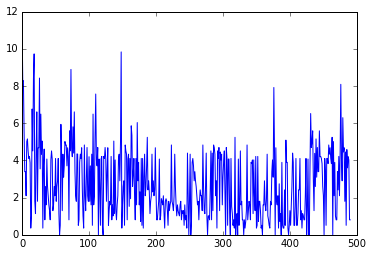

In [28]:
vis.plot_speed(speed)

In [29]:
def plot(items):
    """
    A short plotting utility function.
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()

    ax.plot([i[1] for i in items],[i[0] for i in items],'o-', color='b')
            
    plt.show()

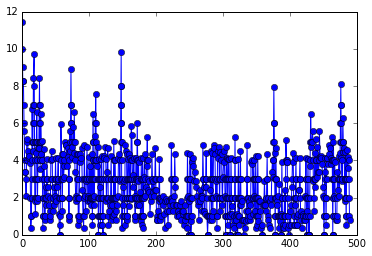

In [30]:
def interpolate_speed(_speed):
    """
    This function interpolates between speed points and adds a time point for every integer speed value.
    """
    import math
    interpolatedSpeed = []
    
    for t0, s0 in enumerate(_speed[:-1]):
        s1 = _speed[t0+1]
        
        
        interpolatedSpeed.append((s0,t0))
        
        left = min(s0, s1)
        right = max(s0,s1)
        #print "left {0} right {1}".format(left, right)
        for point in range(int(math.ceil(left)), int(math.floor(right))):
            t = (point - s0)/(s1-s0)+t0
            #print point, t
            interpolatedSpeed.append((point,t))
            
    return interpolatedSpeed

interpolated_speed = interpolate_speed(speed)
plot(interpolated_speed)

In [31]:
def bin_speed_interval(_speed, _from, _to):    
    """
    Returns time values where the speed falls between the given _from and _to margins. 
    @return time points and the speed value for points where speed lies in the requested interval.
    @rtype: list(tuple)
    """
    acc = get_acceleration(_speed)
    
    _speed = _speed[1:]
    
    intervals = []
    # start at index 2 due to shift of indices after deriving distance to acceleration
    for (sp, ac) in zip(_speed, acc):
        if (sp[0] >= _from and sp[0] <= _to) and ac > 0:
            intervals.append((sp[0],sp[1]))
        
    return intervals

In [32]:
def get_acceleration(speed):
    """
    Computes acceleration for list of speed measurements.
    Acceleration is negative for breaking.
    @rtype list
    """
    acc = []
    for i in range(len(speed)-1):
        if speed[i+1][1] - speed[i][1] == 0.0:
            acc.append(0.0)
        else:
            acc.append((speed[i+1][0] - speed[i][0])/(speed[i+1][1] - speed[i][1]))
    return acc

In [33]:
tentothirty = bin_speed_interval(interpolated_speed, 10, 30)

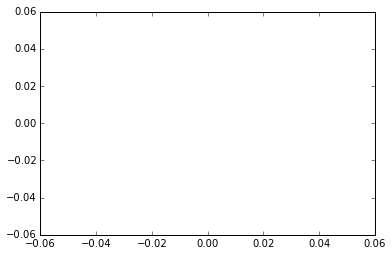

In [34]:
plot(tentothirty)

The plot above displays the speed distribution in the selected speed interval (10 to 30 kmph).

In [35]:
def find_intervals(_tentothirty):
    """
    Splits a list of points into connected intervals. 
    Points inside one interval are adjacent to each other. 
    Speed increases along the interval.
    Intervals are separated by at least one point where speed decreases.
    """
    intervals = []
    pop = []
    for point in _tentothirty:
        if len(pop) > 0 and point < pop[-1]:
            if len(pop) > 3:
                intervals.append(pop)
                
            pop = []
            
        pop.append(point)
    if len(pop) > 3:
        intervals.append(pop)
    
    return intervals

intervals = find_intervals(tentothirty)

In [36]:
def compute_acceleration_feature(_intervals):
    """
    This function computes acceleration feature for a list of connected, 
    disjoint intervals with increasing speed.
    
    Mean acceleration across all intervals is chosen as the acceleration feature.
    """
    prefeature = []
    for interval in _intervals:
        if interval[-1][0] - interval[0][0] < 0.1:
            continue
            
        value = (interval[-1][1] - interval[0][1])/(interval[-1][0] - interval[0][0])
        prefeature.append(value)

    import numpy
    m = numpy.mean(prefeature)
    s = numpy.std(prefeature)
        
    return m

In [38]:
feature_array = []
import math
for i in range(1,200):
    _trip = io.get_trip(2,i, pathToDriverData)
    speed = helpers.get_speed(_trip)
    interpolated_speed = interpolate_speed(speed)
    feature_val = []
    for (interval_begin, interval_end) in [(10,30), (31,50), (51, 70)]:
        interval = bin_speed_interval(interpolated_speed, interval_begin, interval_end)
        contiguous_intervals = find_intervals(interval)
        feature_val.append( compute_acceleration_feature(contiguous_intervals) )
        
    if all(not math.isnan(val) for val in feature_val):
        feature_array.append([i] + feature_val)

features = numpy.array(feature_array)
    
import matplotlib.pyplot as plt
ax = plt.plot([f[1:] for f in features], '+')

/home/igor/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/igor/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/igor/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/igor/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:95: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/igor/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'numpy' is not defined

Above is the plot of features that we want to use for ML. 

# Part2. Machine learning
## Trying different algorithms
Next we want to filter out the outliers with scikit-learn.

In [ ]:
import sklearn

First, lets try K-means algorithm.

In [ ]:
from sklearn.cluster import KMeans 
#filtered_features = [f for f in feature1030 if not math.isnan(f[1])]
##print filtered_features[13]
##print filtered_features
#data = numpy.array(filtered_features)
##print data
#n_samples, n_features = data.shape
#estimator = KMeans(init='k-means++', n_clusters=8, n_init=10)
#estimator.fit(data)
#estimator.labels_

Now, let's try something that works: [Elliptic Envelope](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html)

In [ ]:

clf = covariance.EllipticEnvelope(contamination=.1)
clf.fit(features)  
y_pred = clf.decision_function(features).ravel()

# define a threshold for probabilities
outliers_fraction = 0.02
from scipy import stats
threshold = stats.scoreatpercentile(y_pred, 100 * outliers_fraction)
#y_pred = y_pred > threshold
#print y_pred

# plot results
plt.scatter([i[1] for i in features], [i[2] for i in features], c=[i[3] for i in features], cmap='jet')

Idea: try to fit the model for each feature separately, then compute the sum of probabilities of each point being an outlier.

In [ ]:
for index in range(3):
    data= numpy.array([[f[0], f[index+1]] for f in features])
    clf = covariance.EllipticEnvelope(contamination=.1)
    clf.fit(data)  
    y_pred = clf.decision_function(data).ravel()
    #print y_pred

    # plot results
    plt.scatter([d[0] for d in data], [d[1] for d in data], c=y_pred, cmap='jet')

We have fitted an elliptic envelope model into the space with 3 features:
- average acceleration between 10 and 30 kmph,
- 31 and 50, and
- 51 and 70 kmph.

Next, we have to make sure that an elliptic envelope model is suitable for n-dimensional clustering problems. Consider applying [one-class SVM](http://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#example-svm-plot-oneclass-py). For more outlier detection methods, see [scikit-learn docs](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html).